In [1]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Conv1D, MaxPooling1D, Dropout
from keras.models import Model
import nlpaug
# import nlpaug.augmenter.text as nat
# import nlpaug.augmenter.text as nat
import nlpaug.augmenter.word.word_embs as nat
import random

import os
import glob
# cwd = os.path.abspath('../Dataset/')

# file_list = os.listdir('../Dataset')
# file_list

# csv_files = glob.glob('*.{}'.format('csv'))

# csv_files



df = pd.read_csv('deceptive-opinion.csv')
pd.set_option('display.max_colwidth', None)



# def augment_text_data(texts, n_aug=2):
#     augmented_texts = []
#     aug = nat.WordEmbsAug(model_type='glove', model_path='../../glove.6B.50d.txt')
#     for text in texts:
#         for i in range(n_aug):
#             augmented_texts.append(aug.augment(text))
#     return augmented_texts

# # Read in the original dataset
# # df = pd.read_csv('original_dataset.csv')

# # Get the text column from the dataset
# texts = df['text'].tolist()

# # Augment the text data
# augmented_texts = augment_text_data(texts, n_aug=1)

# # Shuffle the augmented texts
# augmented_texts = random.sample(augmented_texts, len(augmented_texts))

# # Add the augmented texts to the original dataset
# df['augmented_text'] = augmented_texts

# # Save the augmented dataset to a new file
# df.to_csv('augmented_dataset.csv', index=False)





2023-04-09 21:13:57.077091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (however, we left on a Sunday morning, not exactly a high traffic time although it was a Bears homegame day, so a bit busier than usual I would think). No problems at all and the best part is that we got a rate of $100 through Hotwire, a downright steal for this area of Chicago and the quality of the hotel. \n"
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,"Problems started when I booked the InterContinental Chicago online at the hotel's site, and got a server error. Somehow I managed to get my reservation, and wish I had looked elsewhere on this great Chicago street, filled with plenty of other options. The server errors continued at check in and didn't let up. I was on a holiday weekend, but far too many others must have been pushy conventioneers, and I had trouble getting served. The hotel is enormous and doesn't give a sense of comfort. The health facilities are also just too big, so noisy and crowded. And Internet access was $18 a day, kind of surprising when I can go

In [3]:
df[df.isnull()].count()

deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64

<AxesSubplot:xlabel='deceptive', ylabel='count'>

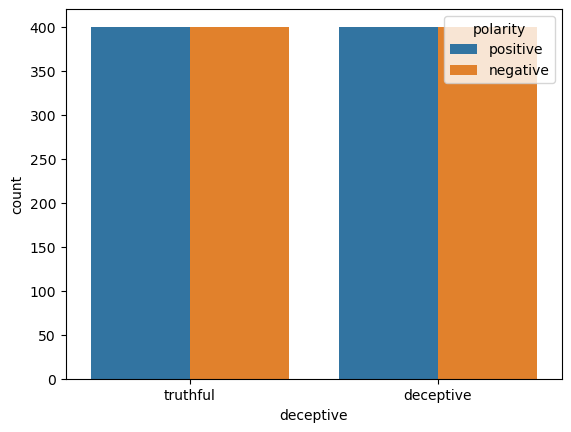

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['deceptive'], hue='polarity', data = df)

In [5]:
df=df.drop(['hotel'],axis=1)


In [6]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string 
def text_cleaning(text):
    '''
        Make text lowercase, remove text in square brackets, remove link, remove special characters, 
        and remove words containing numbers.
    '''
    
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('\\W'," ", text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text


In [7]:
df['text']=df['text'].apply(text_cleaning)


In [8]:
df

,deceptive,polarity,source,text
0,truthful,positive,TripAdvisor,we stayed for a one night getaway with family on a thursday triple aaa rate of was a steal floor room complete with plasma tv bose stereo voss and evian water and gorgeous bathroom no tub but was fine for us concierge was very helpful you cannot beat this location only flaw was breakfast was pricey and service was very very slow for four kids and four adults on a friday morning even though there were only two other tables in the restaurant food was very good so it was worth the wait i would return in a heartbeat a gem in chicago
1,truthful,positive,TripAdvisor,triple a rate with upgrade to view room was less than which also included breakfast vouchers had a great view of river lake wrigley bldg tribune bldg most major restaurants shopping sightseeing attractions within walking distance large room with a very comfortable bed
2,truthful,positive,TripAdvisor,this comes a little late as i m finally catching up on my reviews from the past several months a dear friend and i stayed at the hyatt regency in late october for one night while visiting a friend and her husband from out of town this hotel is perfect imo easy check in and check out lovely clean comfortable rooms with great views of the city i know this area pretty well and it s very convenient to many downtown chicago attractions we had dinner and went clubing with our friends around division st we had no problems getting cabs back and forth to the hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel parking as is usual for chicago was expensive but we were able to get our car out quickly however we left on a sunday morning not exactly a high traffic time although it was a bears homegame day so a bit busier than usual i would think no problems at all and the best part is that we got a rate of through hotwire a downright steal for this area of chicago and the quality of the hotel
3,truthful,positive,TripAdvisor,the omni chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on michigan avenue while this address in chicago requires a high level of quality the omni delivers check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in chicago even the standard room has a separate living area and work desk the fitness center has free weights weight machines and two rows of cardio equipment i shared the room with others and did not feel cramped in any way all in all a great property
4,truthful,positive,TripAdvisor,i asked for a high floor away from the elevator and that is what i got the room was pleasantly decorated functional and very clean i didn t need a whole lot of service but when i did they were pleasant and prompt i used the fitness center which was well equipped and everything was in working order it is in a great location at one end of the michigan avenue shopping district
...,...,...,...,...
1595,deceptive,negative,MTurk,problems started when i booked the intercontinental chicago online at the hotel s site and got a server error somehow i managed to get my reservation and wish i had looked elsewhere on this great chicago street filled with plenty of other options the server errors continued at check in and didn t let up i was on a holiday weekend but far too many others must have been pushy conventioneers and i had trouble getting served the hotel is enormous and doesn t give a sense of comfort the health facilities are also just too big so noisy and crowded and internet access was a day kind of surprising when i can go around the corner to a starbucks next time i ll pick a more intimate place nearby without so many server errors
1596,deceptive,negative,MTurk,the amalfi hotel has a beautiful website and interior decorating but

In [9]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/deth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
sentences=df['text'].values
y=df['deceptive'].values


In [11]:
y

array(['truthful', 'truthful', 'truthful', ..., 'deceptive', 'deceptive',
       'deceptive'], dtype=object)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer()
# sentences = vectorizer.fit_transform(sentences)

In [15]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline



sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,y, test_size=0.2, shuffle=True,
                                                                    random_state=1000)

sentences_train, sentences_val, y_train, y_val = train_test_split(sentences_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

# pipeline = Pipeline([
#     ('tokenizer', Tokenizer(num_words=20000)),
#     ('pad_sequences', pad_sequences(maxlen=100, padding='post')),
#     ('tfidf', TfidfVectorizer(max_features=20000)),
# ])

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences_train)

x_train = tokenizer.texts_to_sequences(sentences_train)
x_test = tokenizer.texts_to_sequences(sentences_test)
x_val = tokenizer.texts_to_sequences(sentences_val)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
# x_train = pipeline.fit_transform(sentences_train)
# x_val = pipeline.transform(sentences_val)
# x_test = pipeline.transform(sentences_test)
x_train = pad_sequences(x_train, padding = 'post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding = 'post', maxlen=maxlen)
x_val = pad_sequences(x_val,padding = 'post',maxlen=maxlen)


# tfidf = TfidfVectorizer()
# tfidf.fit(sentences_train)
# x_train_tfidf = tfidf.transform(sentences_train)
# x_test_tfidf = tfidf.transform(sentences_test)
# x_val_tfidf = tfidf.transform(sentences_val)

# # Concatenate the Tokenizer output and TfidfVectorizer output
# x_train = np.concatenate([x_train, x_train_tfidf.toarray()], axis=1)
# x_test = np.concatenate([x_test, x_test_tfidf.toarray()], axis=1)
# x_val = np.concatenate([x_val, x_val_tfidf.toarray()], axis=1)


# build model using train and validation data

In [16]:
# embedding_dim = 100

# cnn_model = Sequential()

# cnn_model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))


# Original Params : filters = 128, LSTM=250, and add all regularizer back

# cnn_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=3))

# cnn_model.add(LSTM(200))

# cnn_model.add(layers.Dropout(rate = 0.4))
# cnn_model.add(Dense(units=1, activation='sigmoid',kernel_regularizer=reg))

# x = cnn_layer(x)
# x = dropout_layer(x)
# x = pooling_layer(x)
# x = dropout_layer(x)

# history_c = cnn_model.fit(x_train, y_train,
#                     epochs=100,
#                     validation_data=(x_test, y_test),
#                     batch_size=10)

In [17]:
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import BaggingClassifier
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout1D
from sklearn.metrics import accuracy_score



def create_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=maxlen))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(SpatialDropout1D(0.2))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Wrap the Keras model with a scikit-learn classifier for bagging
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)
bagging_model = BaggingClassifier(base_estimator=model, n_estimators=15, random_state=100)

# Train the bagging model on the training set
bagging_model.fit(x_train, y_train)

# Evaluate the bagging model on the test set
y_pred = bagging_model.predict(x_test)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/var/folders/rs/9j57x0q16d9722p1wf50s4vw0000gn/T/ipykernel_2483/2602703346.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)
/Users/deth/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
2023-04-09 21:14:14.865386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


10/10 [==============================] - 0s 12ms/step
Accuracy: 50.94%


In [18]:
import pickle
pickle.dump(bagging_model, open('bagging_model_CNNLSTM.pkl', 'wb'));
# cnn_model.save('model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......spatial_dropout1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-09 21:25:23         3112
metadata.json                                 

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-04-09 21:25:24         3128
metadata.json                                  2023-04-09 21:25:24           64
variables.h5                                   2023-04-09 21:25:24     11241704
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......spatial_dropout1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
......

In [19]:
pkl = open('bagging_model_CNNLSTM.pkl', 'rb');
clf = pickle.load(pkl);

new_text = "During my holiday at Bali, I stayed at Hilton hotel. We arrived there at 12am. There was no staff. No one is coming to help us. We have to carry our luggae to the room. There was monkey everywhere. My girlfriend is afraid of monkey and she's not coming to the room. She has a terrible experience. So am I. If only we can get rid of the monkey and the staff is helpful, that would be nice. Why? because the place itself is big and the room is comfortable. The environment is good except the monkey. The service is kind of not so good."
new_sequence = tokenizer.texts_to_sequences([new_text])
# print(new_sequence)
new_data = pad_sequences(new_sequence, maxlen=maxlen)
# print(new_data)
prediction = clf.predict(new_data)
print(prediction)
prediction_label = np.round(prediction[0])
print(prediction_label)
print("truthful" if prediction_label==1 else "deceptive")


Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-09 21:25:22         3112
metadata.json                                  2023-04-09 21:25:22           64
variables.h5                                   2023-04-09 21:25:22     11241704
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......spatial_dropout1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.....

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-09 21:25:24         3128
metadata.json                                  2023-04-09 21:25:24           64
variables.h5                                   2023-04-09 21:25:24     11241704
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......conv1d
.........vars
............0
............1
......dense
.........vars
............0
............1
......embedding
.........vars
............0
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......max_pooling1d
.........vars
......spatial_dropout1d
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.....

1/1 [==============================] - 0s 191ms/step
[0]
0
deceptive


In [20]:
df_test = pd.read_csv('../FakeReviewDataset.csv')
df_test

,category,rating,label,text_
0,Home_and_Kitchen_5,5,deceptive,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty"
1,Home_and_Kitchen_5,5,deceptive,"love it, a great upgrade from the original. I've had mine for a couple of years"
2,Home_and_Kitchen_5,5,deceptive,This pillow saved my back. I love the look and feel of this pillow.
3,Home_and_Kitchen_5,1,deceptive,"Missing information on how to use it, but it is a great product for the price! I"
4,Home_and_Kitchen_5,5,deceptive,Very nice set. Good quality. We have had the set for two months now and have not been
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4,truthful,"I had read some reviews saying that this bra ran small and so I ordered TWO band AND cup sizes UP and it was still too small! Definitely along the lines of a sports bra squish effect. The sides do come up high. Glamorise is one the best brands for bras, so I'm very surprised with this one. The front close idea appealed to me, but look carefully, there are 7 (yes, seven) clasps to do up. What a pain. I think if I had ordered 3 sizes up it might be ok. I won't return it as I'm losing weight, so it might fit better down the road. Will update review at that time. If you want a bra that doesn't let you jiggle at all without it being a minimizer and/or without wires, this would be good.\n\nUPDATE: After very recent gallbladder surgery that left me with a highly tender incision site, I found I couldn't wear any of my regular bras. I had ordered this one hoping I might be able to tolerate it. Initially, because it was so tight, I couldn't tolerate this one either. As I slowly healed, I kept trying the bra. Due to its elastic nature I was able to adjust this for comfort more than the others. After about two weeks, much to my amazement, I found the bra had lost its initial snugness and was in fact VERY comfortable! 5 weeks after surgery and this is still the only bra I can tolerate. The number of clasps in the front turned out to be a bonus as well, because I could choose to leave the bottom clasps undone, adding to the comfort level. I am still of the opinion that it runs too snug and I'm glad I ordered up.\n\nTake the time to break the bra in! All bras have a break-in period (in my opinion), and this one is no different. I'm actually quite happy with it now."
40428,Clothing_Shoes_and_Jewelry_5,5,deceptive,"I wasn't sure exactly what it would be. It is a little large for my small size, but I think it is a nice fit. The fabric is a nice thin material, but it is a little thin in the legs. I wish it was thicker. The material is soft and comfortable. I will keep it. I ordered a half size up and it fits great. I wear a 9 1/2. I like that the strap is longer than the waistband, which is nice. I am 5'5"" and the size 6 fits great. I am a medium. The bra is too short. It is a little narrow for me, but I think it would be a nice addition to my wardrobe. I will be buying another one in different colors. I have a small tummy and I ordered a medium. I wear a 9 1/2 in pants. I would recommend this bra. I am 5'8"" and the length was perfect. I love the color and it is very comfortable.\nI would recommend this to anyone.I was very happy with this shirt! It's very pretty and the fabric is soft and nice! The fit is perfect! I bought a small and it fit perfectly! It is well made and it's very comfortable.I like the leggings but they are not as comfortable. I am a 36D and ordered a medium and it was too big. I am going to return it. I returned it. I am very pleased with this purchase and will be ordering another one.I bought these shoes to wear to work when I was out walking in the rain."
40429,Clothing_Shoes_and_Jewelry_5,2,truthful,"You can wear the hood by itself, wear it with the hood, or wear just the jacket without the hood. How is that for 3-in-1 systems?\n\nReminiscent of what Lands End sells as a ""Squall Jacket"", or what uniform and corporate wear sellers call a Three Season Jacket.\n\nWater and wind

In [21]:
x = df_test['text_']
y_val = df_test['label']

In [22]:
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, padding = 'post', maxlen=maxlen)


In [23]:
y_pred = np.round(clf.predict(x).ravel())
y_pred

1264/1264 [==============================] - 12s 10ms/step


array([0, 1, 0, ..., 0, 1, 1])

In [24]:
y_pred_label_test = []
for i in y_pred:
    if i == 1:
        y_pred_label_test.append("truthful")
    else:
        y_pred_label_test.append("deceptive")

        
y_label_test = []
for i in y_val:
    if i == 1:
        y_label_test.append("truthful")
    else:
        y_label_test.append("deceptive")


In [25]:
predict_val = pd.DataFrame({'dataTest':df_test['text_'], 'Pred':y_pred_label_test, 'True_label':y_label_test}, columns=['dataTest','Pred','True_label'])
predict_val['result'] = np.where(predict_val['Pred']==predict_val['True_label'], 1, 0)
# results.sort_values(by='result').head(20)


predict_val.sort_values(by='result')

,dataTest,Pred,True_label,result
40431,"I work in the wedding industry and have to work long days, on my feet, outside in the heat, and have to look professional. I've spent a ridiculous amount of money on high end dress shoes like Merrels and just have not been able to find a pair that are comfortable to wear all day. Both for my feet and my back. Enter the Sanuk yoga sling!!! These shoes are amazingly comfortable. Though, I will admit it took a few wears to get used to the feel of the yoga matte bottom. At first, it felt a little ""sticky"" to me, and the fabric part that goes through the toe area was a little thick and took some getting used to. I wore them for a few days before taking them out on a job and I can't get over how comfortable they are. Ii have been wearing these shoes now for 3 months, every work day and I am THRILLED. No more back pain, no more sore feet. I also wear these sometimes during my off time,mans every time I wear them, I get compliments on how cute and comfortable they look. The great thing about these shoes is the yoga matte bottom. It helps your feet grip to the shoe a bit, so your foot can just walk normally, without having to grip the shoe. You may not realize it, but with a lot of Sandals, your foot is having to work to keep the shoe on, changing the way you walk and stand and ultimately causing foot and back pain. Not with these! Also, the soft linen sits comfortably on your skin and breathes nicely in the heat. The only downside is the funky tan lines, which is why I am sure to alternate shoes on my days off, especially if I plan to be outside for most of the day. If it were not for that, I think these might be the only shoes I'd wear all summer. If you are looking for a reasonable priced, comfortable shoe that you can wear and walk in all day.",truthful,deceptive,0
32265,"I usually spend these reviews on an academic level, but I really enjoyed this book. It has a lot of interesting historical information. The characters are interesting, and the plots are very interesting. I think this is one of the better novels on the subject. This is a great read for anyone interested in history. I received this book free from the publisher through NetGalley in exchange for an honest review. This book was a total shocker. It's very sad that this book is out of print. The author, William F. Martin, wrote a book that was so bad it's hard to put down. However, the author went out of his way to make the book look like a ghost story. It's a shame because this is one of the worst books I have read in a long time. I'm going to read it again. I really enjoyed the book. It's a great read. I can't wait for the next book in this series.",truthful,deceptive,0
32267,"Well, that's that... I gave Jordan three chances to get the series back to what it used to be, and it's just not happening. I won't be buying another Wheel of Time book in hardcover. In fact, I may just go to the library and check a copy out next time, rather than even buying it in paperback.\nI used to be impressed by Jordan's ability to have so many plot threads going on at once, and yet tying them all together. Now I'm just bored by it. He has too many characters doing their own little thing in their own little places... I can't fault him too much for not moving the series forward, the problem is with the way he has the story set up, he _Can't_. There are too many plots... but he could do a much better job in focusing in on those plots and making something happen within them. The female characters are extremely under-developed. They're all so similar... But again, an author must have a hard time developing characters when he's thrown so many into the mix.\nThe end of this book was fairly decent. I can't say this book was better than the last two, however.",truthful,deceptive,0
32269,"Wow, this book will be a real hit with the teens.\n\nThe story starts when one of the two girls, Kail, is attacked by the mysterious ""good"" guy, The Penelope. It takes a

In [26]:
wrong = 0
right = 0
for i in predict_val['result']:
    
    if i == 0:
        wrong+=1
    else:
        right+=1

print("The wrong guess is : ", wrong)
print("The right guess is: ", right)
    

The wrong guess is :  20984
The right guess is:  19448
